In [3]:
import xgboost as xgb            # XGBoost's sklearn‑style estimator
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import numpy as np

# -------------------------------------------------------------
#  Load data
# -------------------------------------------------------------
X, y = load_breast_cancer(return_X_y=True)  # Features + binary target

# -------------------------------------------------------------
# Train / test split
# -------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# -------------------------------------------------------------
# Build an XGBClassifier (sklearn interface)
# -------------------------------------------------------------
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',   # Binary classification
    eval_metric='logloss',         # Evaluation metric
    n_estimators=200,              # Number of boosting rounds
    learning_rate=0.05,            # Step size shrinkage
    max_depth=4,                   # Depth of each tree
    subsample=0.8,                 # Subsample ratio of the training instances
    colsample_bytree=0.8,          # Subsample ratio of columns when constructing each tree
    reg_lambda=1,                  # L2 regularization term on weights
    n_jobs=-1,                     # Use all cores
    random_state=42
)

# -------------------------------------------------------------
#  Train the model
# -------------------------------------------------------------
xgb_clf.fit(X_train, y_train)

# -------------------------------------------------------------
# Predict & evaluate
# -------------------------------------------------------------
y_pred = xgb_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -------------------------------------------------------------
# Optional: Hyper‑parameter search with GridSearchCV
# -------------------------------------------------------------
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("\nBest params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Use the best estimator for final evaluation
y_pred_best = grid.best_estimator_.predict(X_test)
print("\nAccuracy with best params:", accuracy_score(y_test, y_pred_best))

Accuracy: 0.956140350877193

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.99      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV score: 0.9714331358196816

Accuracy with best params: 0.9473684210526315


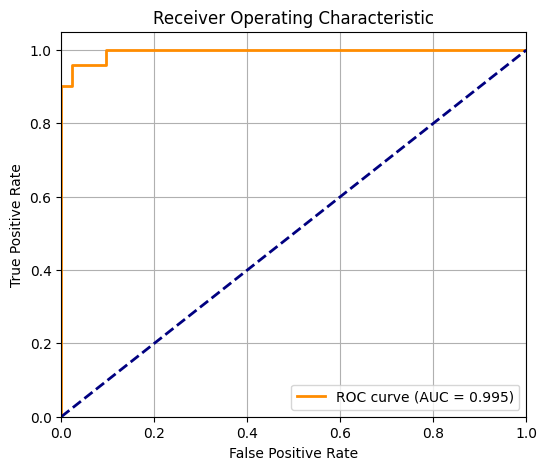

In [4]:
y_proba = xgb_clf.predict_proba(X_test)[:, 1]   # probability of class 1

# --------------------------------------------------------------
# Compute ROC curve & AUC
# --------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# --------------------------------------------------------------
# Plot ROC curve
# --------------------------------------------------------------
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
